# the script implemented in a notebook to look at whats happening

In [ ]:
### FOM_fitter.ipynb made into a job

# import stuff
import sys,os,os.path
import csv

#sys.path.append("../../")   # cite IC from parent directory
sys.path.append("/scratch/halmazan/NEXT/IC_alter-blob-centre/")
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
sys.path.append("/scratch/halmazan/NEXT/testing/notebooks/FOM_creator/")
os.environ['ICTDIR']='/scratch/halmazan/NEXT/IC_alter-blob-centre/'

from invisible_cities.core.core_functions   import shift_to_bin_centers
from invisible_cities.io.dst_io           import load_dst, load_dsts, df_writer

import FOM_functions as FOM_func
import functions_HE as func
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import probfit



import scipy.special as special
from scipy.stats import norm
from scipy.stats import skewnorm, crystalball
from scipy.optimize import curve_fit
from tqdm import tqdm

from scipy.integrate import quad

import iminuit
from iminuit import Minuit

from concurrent.futures import ProcessPoolExecutor

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import tables as tb
from matplotlib import colors 

from typing          import Optional
from typing          import Union
from typing          import Callable

from concurrent.futures import ProcessPoolExecutor

import sys,os,os.path
from pathlib import Path

from invisible_cities.io.dst_io           import load_dst, load_dsts, df_writer
from invisible_cities.io.hits_io          import hits_writer
from invisible_cities.core                import tbl_functions   as tbl
from invisible_cities.core.core_functions import in_range
#from invisible_cities.cities.beersheba    import hitc_to_df_
from invisible_cities.io.hits_io          import hits_from_df
from invisible_cities.evm.nh5             import HitsTable
from invisible_cities.types.symbols       import NormStrategy
from invisible_cities.types.ic_types      import NoneType
from invisible_cities.reco.corrections    import read_maps, get_df_to_z_converter, apply_all_correction
from invisible_cities.evm.event_model     import HitCollection

from tqdm import tqdm


def load_single_file(file_path):
    '''
    Load data from a single h5 file and produce dataframes for /Tracking/Tracks

    Args:
        file_path       :       str
                                Path to the h5 file to be loaded.

    Returns:
        tracks_df       :       pandas.DataFrame
                                DataFrame containing the /Tracking/Tracks data.
    '''
    try: 
        tracks_df = load_dst(file_path, 'Tracking', 'Tracks')
        return tracks_df
    except Exception as e:
        print(f'File {file_path} broke with error:\n{e}', flush = True)
        x = pd.DataFrame()
        return x

## FUNCTIONS ##

def load_data_fast(folder_path):
    '''
    Load multiple h5 files and produce concatenated dataframes for /Tracking/Tracks, /MC/Particles, and their corresponding eventmap.

    Args:
        folder_path     :       str
                                Path to the folder containing the h5 files.

    Returns:
        tracks          :       pandas.DataFrame
                                Concatenated DataFrame containing the /Tracking/Tracks data from all h5 files.
        
        particles       :       pandas.DataFrame
                                Concatenated DataFrame containing the /MC/particles data from all h5 files, with the 'event_id' column modified.

        eventmap        :       pandas.DataFrame
                                Concatenated DataFrame containing the event map from all h5 files.
    '''
    
    file_names = [f for f in os.listdir(folder_path) if f.endswith('.h5')]
    file_paths = [os.path.join(folder_path, f) for f in file_names]

    # Use ProcessPoolExecutor to parallelize the data loading process
    with ProcessPoolExecutor() as executor:
        results = list(executor.map(load_single_file, file_paths))
    
    # Separate the results into respective lists
    tracks_list = results

    # Concatenate all the dataframes at once
    tracks = pd.concat(tracks_list, axis=0, ignore_index=True)

    return tracks


def load_data(pth):
    hdst = []

    for i in tqdm(range(1,8)):
        print(f"LDC {i}", flush = True)
        flder_pth = pth + 'ldc' + str(i) + '/'
        hdst.append(load_data_fast(flder_pth))

    hdst = pd.concat(hdst)
    return hdst



def main(RUN_NUMBER, 
         TIMESTAMP, 
         CITY,
         FOM_TS):
    
    print('=' * 20, flush = True)
    print(f'RUNS: {RUN_NUMBER}\nTIMESTAMPS: {TIMESTAMP}', flush = True)
    print('=' * 20, flush = True)




    # make directory
    pre_dir = '/scratch/halmazan/NEXT/PROCESSING/FOM/data/'
    folder_name = f'{pre_dir}/{FOM_TS}'
    folder_s = Path(f'{folder_name}')
    folder_s.mkdir(parents=True, exist_ok=True)


    # load
    hdst_local = []
    for RN, TS in zip(RUN_NUMBER, TIMESTAMP):
        print(f'R{RN}: {TS}', flush = True)
        n100_dir = f'/scratch/halmazan/NEXT/PROCESSING/topology_cuts/data/{RN}/{TS}/'
        hdst_local.append(pd.read_hdf(f'{n100_dir}cut_hdst.h5'))
        print(f'Loaded!', flush = True)
    hdst = pd.concat(hdst_local)
 

    # quick plot for sanity reasons.
    plt.hist(hdst.energy, bins = 100)
    plt.title(f"FULL DATASET ENERGY DISTRIBUTION")
    plt.xlabel("Energy (MeV)")
    plt.ylabel("Counts")
    plt.savefig(f'{folder_name}/hist_plot.pdf')
    plt.close()

    vars = 'energy'
    labels = '(MeV)'
    log_flag = False
    print('=' * 20, flush = True)
    print('data loaded', flush = True)

    # DEFINING ALL THE FUNCTIONS INSIDE CAUSE IM SCARED

    def sig_func(x, ns, beta, m, loc, scale):
        '''
        signal function now defined by a crystal ball
        Args:
            x       : numpy.ndarray
                      Independent variable (e.g., energy values).
            ns      : float
                      Normalization factor for the signal component.
            B       : float
                      Background parameter  related to the exponential decay.
            M       : float
                      Mean value of the crystal ball distribution, representing the peak position.
        Returns:
            numpy.ndarray
            The evaluated signal function values for the given input parameters.
        '''

        return ns * (crystalball.pdf(x, beta, m, loc = loc, scale = scale))


    def sig_func_no_N(x, B, M, loc, scale):
        '''
        signal function now defined by a crystal ball
        Args:
            x       : numpy.ndarray
                      Independent variable (e.g., energy values).
            B       : float
                      Background parameter  related to the exponential decay.
            M       : float
                      Mean value of the crystal ball distribution, representing the peak position.
        Returns:
            numpy.ndarray
            The evaluated signal function values for the given input parameters.
        '''

        return (crystalball.pdf(x, B, M, loc = loc, scale = scale))

    def sig_bck_func(x, ns, nb, B, M, tau, loc, scale):
        return (sig_func(x, ns, B, M, loc, scale) + FOM_func.bck_func(x, nb, tau))


    def add_element(dict, key, value):
        if key not in dict:
            dict[key] = value

    def gaussian_fit(data, plot = False):
        '''
        Fit gaussian to the data
        '''
        blob_np = data['energy'].to_numpy()

        # produce gaussian fit
        lh_g = probfit.BinnedLH(gauss_norm_ext_, blob_np, extended = True)
        vals_g = [len(blob_np), 1.59, 0.004]
        nm_g = ['Ng', 'mu', 'sigma']

        m_g = Minuit(lh_g, **dict(zip(nm_g, vals_g)), 
                    limit_mu=(fit_range[0], fit_range[1]), limit_Ng=(0,None), limit_sigma=(0,1))
        m_g.print_level = 1  # Set verbosity level to show progress during minimization
        print("Starting minimization with migrad...", flush = True)
        # minimise it
        m_g.migrad()


        if (plot == True):
            # plot output
            heights, bins, _ = plt.hist(blob_np, binning)
            plt.xlabel("Track energy (MeV)")
            plt.ylabel("Counts/bin")
            lh_g.show(, parts=True)
            plt.show()

        # pull out the relevant values
        fit_params = {}
        [add_element(fit_params, m_g.params[i][1],m_g.params[i][2]) for i in range(len(m_g.params))]
        mu = fit_params['mu']
        sigma = fit_params['sigma']


        return (mu, sigma)

    def sb_fit(data, mu, sigma, fit_bins, plot = False):
        '''
        Fit signal and background to data
        '''
        blob_np = data['energy'].to_numpy()
        # create signal background pdf
        pdf_sb = probfit.AddPdf(sig_norm_ext, bck_norm_ext)

        lh_sb = probfit.BinnedLH(pdf_sb, blob_np, extended = True)

        y, x = np.histogram(blob_np, fit_bins)
        x = shift_to_bin_centers(x)

        # give it rough starting spots
        vals_sb = [len(blob_np)/2, len(blob_np)/2, 1, 1.1, 0.9, mu, sigma]
        nm_sb = ['Ns', 'Nb', 'B', 'M', 'tau', 'loc', 'scale']

        print('Initial guess:', flush = True)
        FOM_func.print_parameters(vals_sb, list(np.diag(np.zeros_like(vals_sb))), nm_sb)
        #FOM_func.plot_fit(sig_bck_func, np.linspace(data['energy'].min(), data['energy'].max(), 1000), vals_sb, nm_sb, output=True)


        m_sb = Minuit(lh_sb, **dict(zip(nm_sb, vals_sb)), 
                      limit_B = (0, 2),
                      limit_M = (0, None),
                      fix_loc = True,
                      fix_scale = True,
                      limit_tau=(0.001,None),
                      print_level = 2)
        print('Scan and then fit', flush = True)
        # minimise that mfer

        m_sb.migrad()

        if (plot == True):
            # plot output
            heights, bins, _ = plt.hist(blob_np, binning)
            plt.xlabel("Track energy (MeV)")
            plt.ylabel("Counts/bin")
            lh_sb.show(, parts=True)
            plt.show()

        # pull out the relevant values
        fit_params = {}
        [add_element(fit_params, m_sb.params[i][1],m_sb.params[i][2]) for i in range(len(m_sb.params))]

        return (fit_params['Ns'], fit_params['Nb'])


    binning = 80
    cut_list = np.linspace(0,0.5, 21) # normally 51 not 5
    fit_range = [hdst.energy.min(), hdst.energy.max()]



    # normalise and extend
    sig_norm = probfit.Normalized(sig_func_no_N, fit_range)
    sig_norm_ext = probfit.Extended(sig_norm, extname = 'Ns')

    bck_norm = probfit.Normalized(FOM_func.bck_func_no_N, fit_range)
    bck_norm_ext = probfit.Extended(bck_norm, extname = 'Nb')

    gauss_norm = probfit.Normalized(FOM_func.gauss_no_N, fit_range)
    gauss_norm_ext_ = probfit.Extended(gauss_norm, extname = 'Ng')

    # create list for fom values
    e       = []
    b       = []
    ns_l      = []
    nb_l      = []
    fom     = []
    fom_err = []
    e_err = []
    b_err = []




    # apriori
    print('Starting the process...', flush = True)
    # [500, 1.65, 0.01]
    blob_data_fresh = hdst.copy(deep = True)
    func.plot_hist(blob_data_fresh, binning = 70, output = True, log = False)

    gauss_hdst = func.energy_cuts(blob_data_fresh, 1.57, 1.62)
    func.plot_hist(gauss_hdst, binning = 20, output = True, log = False, title = 'Gauss fit bins')
    # fit gaussian for mu and sigma    
    holder = gaussian_fit(gauss_hdst)
    mu = holder[0]
    sigma = holder[1]
    print(f'Gaussian fixed at:\nmu: {mu}\nsigma: {sigma}', flush = True)


    for i in range(len(cut_list)):
        # generate data
        try:
            blob_data = blob_data_fresh[(blob_data_fresh['eblob2'] > cut_list[i])]
            print("", flush = True)
            print("", flush = True)
            print("====================================", flush = True)
            print("Blob cut: {} MeV".format(cut_list[i]), flush = True)
            print("====================================", flush = True)



            fit_bins = np.linspace(fit_range[0], fit_range[1], binning + 1)
            holder_sb = sb_fit(blob_data, mu, sigma, fit_bins, plot = True)

            ns_l.append(holder_sb[0])
            nb_l.append(holder_sb[1])

            print("Signal events: {}\nBackground events: {}\nTotal Events by addition: {}\nTotal Events by row counting: {}".format(ns_l[i], nb_l[i],nb_l[i] + ns_l[i], len(blob_data.index)), flush = True)

            # efficiency and background rej
            e_check = ns_l[i]/ns_l[0]
            b_check = nb_l[i]/nb_l[0]
            fom_check = e_check/np.sqrt(b_check)

            e.append(e_check)
            b.append(b_check)
            fom.append(fom_check)

                # errors for fom
            e_err.append(FOM_func.ratio_error(e[i],ns_l[i],ns_l[0],np.sqrt(ns_l[i]),np.sqrt(ns_l[0])))
            b_err.append(FOM_func.ratio_error(b[i],nb_l[i],nb_l[0],np.sqrt(nb_l[i]),np.sqrt(nb_l[0])))
            fom_err.append(FOM_func.fom_error(e[i], b[i], e_err[i], b_err[i]))
            
            print(f'FOM: {fom}\nfom_err: {fom_err}', flush = True)
            print(f'ns_l: {ns_l}\nnb_l: {nb_l}', flush = True)
            del blob_data, holder_sb

            print("====================================", flush = True)

        except Exception as ex:
            print(f'Yo shit broke!\n{ex}', flush = True)
            ns_l.append(-9999)
            nb_l.append(-9999)
            e.append(-9999)
            b.append(-9999)
            fom.append(-9999)
            e_err.append(-9999)
            b_err.append(-9999)
            fom_err.append(-9999)
            try:
                del blob_data, holder_sb
            except:
                print('Cant delete shit that doesnt exist i guess?', flush = True)
    print(f'FOM:\n{fom}', flush = True)
    print(f'Cut list:\n{cut_list}', flush = True)
    try:
        plt.show()
    except Exception as e:
        print(e, flush = True)
    plt.errorbar(cut_list, fom, yerr = fom_err, label = 'FIT', linestyle = 'dashed')
    plt.legend()
    plt.title(f"FOM LPR R{RUN_NUMBER} - {TIMESTAMP}")
    plt.xlabel("Blob-2 energy threshold (MeV)")
    plt.xlim([0,0.55])
    #plt.ylim([0,2])
    plt.ylabel("fom")
    plt.savefig(f'{folder_name}/FOM_plot.pdf')
    plt.close()

    # save
    with open(f'{folder_name}/FOM.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerows(zip(cut_list, fom))
        writer.writerows(zip(cut_list, fom_err))
        writer.writerows(zip(ns_l, nb_l))
        writer.writerows(zip(e,e_err))
        writer.writerows(zip(b,b_err))



RUNS: [15589, 15590, 15591, 15592, 15593, 15594, 15596]
TIMESTAMPS: [110725, 120725, 130725, 140725, 150725, 160725, 170725]
R15589: 110725
Loaded!
R15590: 120725
Loaded!
R15591: 130725
Loaded!
R15592: 140725
Loaded!
R15593: 150725
Loaded!
R15594: 160725
Loaded!
R15596: 170725
Loaded!
data loaded
Starting the process...


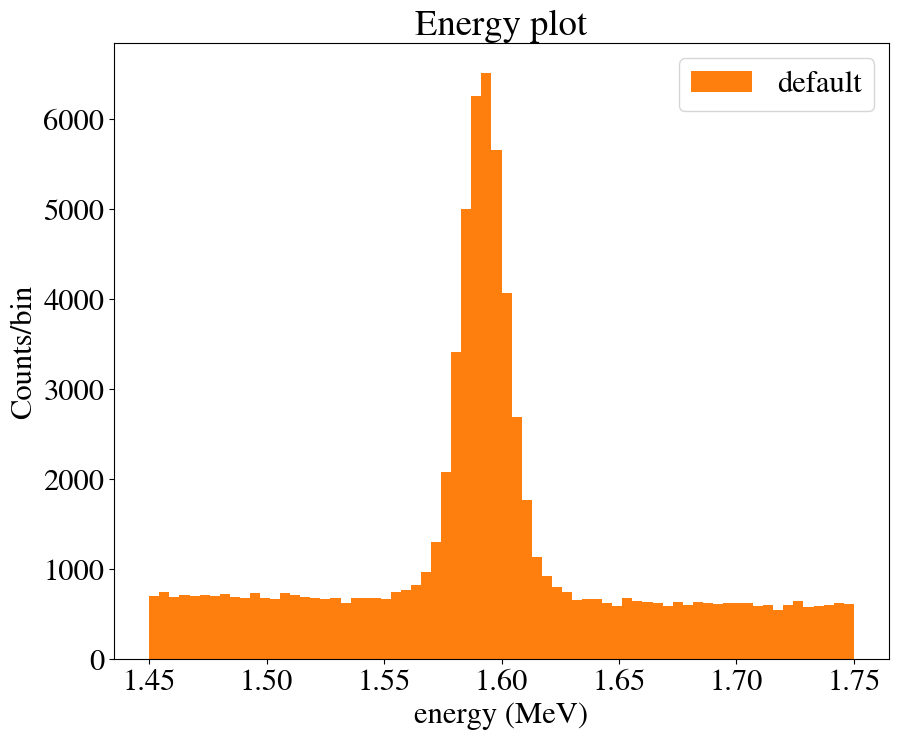

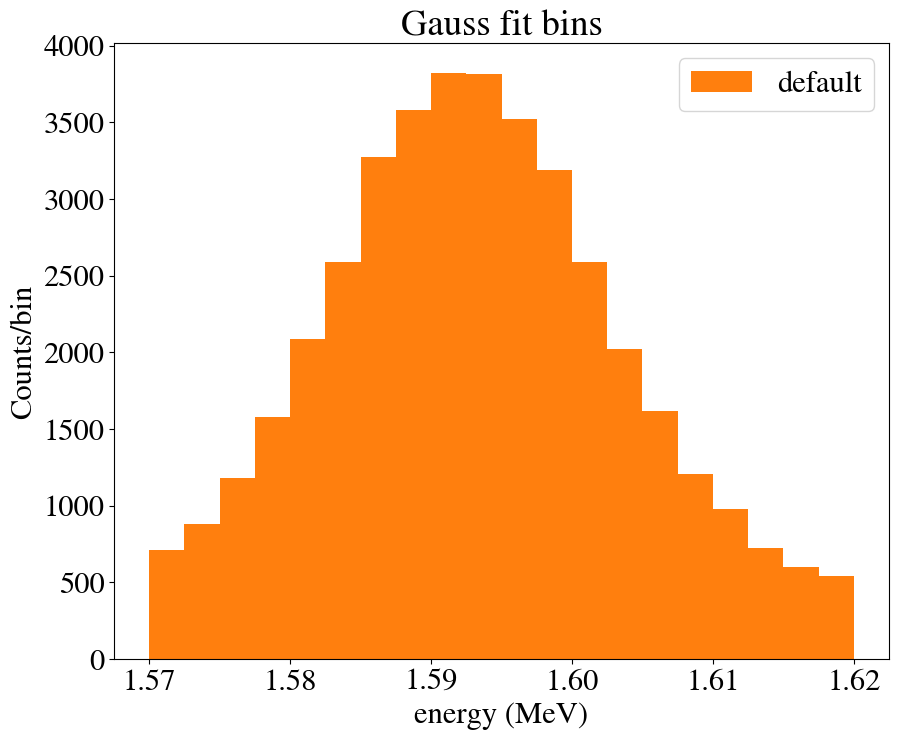

Starting minimization with migrad...
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 217.9                      │         Nfcn = 99 (99 total)         │
│ EDM = 1.2e-05 (Goal: 0.0001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │       SOME Parameters at limit       │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
Gaussian fixed at:
mu: 1.5928556112238248
sigma: 0.011674867907526365


Blob cut: 0.0 MeV
Initial guess:
        Fitting output      
Ns: 39839.0000 ± 0.0000
Nb: 39839.0000 ± 0.0000
B: 1.0000 ± 0.0000
M:

/scicomp/builds/Rocky/8.7/Common/software/Anaconda3/2023.03-1/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:9618: RuntimeWarning: overflow encountered in power
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
/scicomp/builds/Rocky/8.7/Common/software/Anaconda3/2023.03-1/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:9618: RuntimeWarning: invalid value encountered in multiply
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
Info: VariableMetricBuilder: no improvement in line search
Info: VariableMetricBuilder: iterations finish without convergence.
Info in VariableMetricBuilder : edm = 0.0213975
Info in             requested : edmval = 0.0001


VariableMetric: Iteration #  25 - FCN =   431.0443971889 Edm =    0.0143653 NCalls =    373


Info: VariableMetricBuilder: Tolerance is not sufficient, continue the minimization
Info in Current  Edm is : edm = 0.0423935
Info in Required Edm is : edmval = 0.0001


VariableMetric: After Hessian   - FCN =   431.0443971889 Edm =    0.0423935 NCalls =    404
VariableMetric: Iteration #  26 - FCN =   431.0443971889 Edm =    0.0423935 NCalls =    404


Info: VariableMetricBuilder: no improvement in line search
Info: VariableMetricBuilder: iterations finish without convergence.
Info in VariableMetricBuilder : edm = 0.0423935
Info in             requested : edmval = 0.0001
Info: VariableMetricBuilder: FunctionMinimum is invalid after second try


VariableMetric: Iteration #  27 - FCN =   431.0443971889 Edm =    0.0423935 NCalls =    415
VariableMetric: start iterating until Edm is < 0.0001
VariableMetric: Initial state   - FCN =   431.0443971889 Edm =    0.0423934 NCalls =     13
VariableMetric: Iteration #   0 - FCN =   431.0443971889 Edm =    0.0423934 NCalls =     13


Info: VariableMetricBuilder: no improvement in line search
Info: VariableMetricBuilder: iterations finish without convergence.
Info in VariableMetricBuilder : edm = 0.0423934
Info in             requested : edmval = 0.0001
Info in VariableMetricBuilder: INVALID function minimum - edm is above tolerance, : edm = 0.0423934
Info in VariableMetricBuilder: Required tolerance  is 10 x edmval  : edmval = 0.0001


VariableMetric: Iteration #   1 - FCN =   431.0443971889 Edm =    0.0423934 NCalls =     24
VariableMetric: start iterating until Edm is < 0.0001
VariableMetric: Initial state   - FCN =   431.0443971889 Edm =    0.0423934 NCalls =     13
VariableMetric: Iteration #   0 - FCN =   431.0443971889 Edm =    0.0423934 NCalls =     13


Info: VariableMetricBuilder: no improvement in line search
Info: VariableMetricBuilder: iterations finish without convergence.
Info in VariableMetricBuilder : edm = 0.0423934
Info in             requested : edmval = 0.0001
Info in VariableMetricBuilder: INVALID function minimum - edm is above tolerance, : edm = 0.0423934
Info in VariableMetricBuilder: Required tolerance  is 10 x edmval  : edmval = 0.0001


VariableMetric: Iteration #   1 - FCN =   431.0443971889 Edm =    0.0423934 NCalls =     24
VariableMetric: start iterating until Edm is < 0.0001
VariableMetric: Initial state   - FCN =   431.0443971889 Edm =    0.0423934 NCalls =     13
VariableMetric: Iteration #   0 - FCN =   431.0443971889 Edm =    0.0423934 NCalls =     13


Info: VariableMetricBuilder: no improvement in line search
Info: VariableMetricBuilder: iterations finish without convergence.
Info in VariableMetricBuilder : edm = 0.0423934
Info in             requested : edmval = 0.0001
Info in VariableMetricBuilder: INVALID function minimum - edm is above tolerance, : edm = 0.0423934
Info in VariableMetricBuilder: Required tolerance  is 10 x edmval  : edmval = 0.0001


VariableMetric: Iteration #   1 - FCN =   431.0443971889 Edm =    0.0423934 NCalls =     24
VariableMetric: start iterating until Edm is < 0.0001
VariableMetric: Initial state   - FCN =   431.0443971889 Edm =    0.0423934 NCalls =     13
VariableMetric: Iteration #   0 - FCN =   431.0443971889 Edm =    0.0423934 NCalls =     13
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 431                        │        Nfcn = 511 (511 total)        │
│ EDM = 0.0424 (Goal: 0.0001)      │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│INVALID Minimum│ Valid Parameters │       SOME Parameters at limit       │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ ABOVE EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │

Info: VariableMetricBuilder: no improvement in line search
Info: VariableMetricBuilder: iterations finish without convergence.
Info in VariableMetricBuilder : edm = 0.0423934
Info in             requested : edmval = 0.0001
Info in VariableMetricBuilder: INVALID function minimum - edm is above tolerance, : edm = 0.0423934
Info in VariableMetricBuilder: Required tolerance  is 10 x edmval  : edmval = 0.0001


VariableMetric: start iterating until Edm is < 0.0001
VariableMetric: Initial state   - FCN =   3371.557599206 Edm =       3011.4 NCalls =     17
VariableMetric: Iteration #   0 - FCN =   3371.557599206 Edm =       3011.4 NCalls =     17
VariableMetric: Iteration #   1 - FCN =   978.4365286438 Edm =       209.86 NCalls =     35
VariableMetric: Iteration #   2 - FCN =   631.9898479004 Edm =      31.4732 NCalls =     47
VariableMetric: Iteration #   3 - FCN =   561.5833500287 Edm =      34.4653 NCalls =     59
VariableMetric: Iteration #   4 - FCN =   477.1218071568 Edm =      11.1192 NCalls =     79
VariableMetric: Iteration #   5 - FCN =   456.8560087049 Edm =      3.22508 NCalls =     91
VariableMetric: Iteration #   6 - FCN =   448.8859357818 Edm =      1.36203 NCalls =    109
VariableMetric: Iteration #   7 - FCN =   446.9768677828 Edm =    0.0897531 NCalls =    121
VariableMetric: Iteration #   8 - FCN =   446.8210252952 Edm =   0.00931124 NCalls =    133
VariableMetric: Iteration 

Info: VariableMetricBuilder: no improvement in line search
Info: VariableMetricBuilder: iterations finish without convergence.
Info in VariableMetricBuilder : edm = 0.0227851
Info in             requested : edmval = 0.0001


VariableMetric: Iteration #  25 - FCN =   431.0900827226 Edm =      0.01545 NCalls =    372
VariableMetric: After Hessian   - FCN =   431.0900827226 Edm =    0.0436099 NCalls =    403
VariableMetric: Iteration #  26 - FCN =   431.0900827226 Edm =    0.0436099 NCalls =    403


Info: VariableMetricBuilder: Tolerance is not sufficient, continue the minimization
Info in Current  Edm is : edm = 0.0436099
Info in Required Edm is : edmval = 0.0001


VariableMetric: Iteration #  27 - FCN =   431.0900827226 Edm =    0.0436099 NCalls =    414
VariableMetric: start iterating until Edm is < 0.0001
VariableMetric: Initial state   - FCN =   431.0900827226 Edm =    0.0436099 NCalls =     13
VariableMetric: Iteration #   0 - FCN =   431.0900827226 Edm =    0.0436099 NCalls =     13


Info: VariableMetricBuilder: no improvement in line search
Info: VariableMetricBuilder: iterations finish without convergence.
Info in VariableMetricBuilder : edm = 0.0436099
Info in             requested : edmval = 0.0001
Info: VariableMetricBuilder: FunctionMinimum is invalid after second try


VariableMetric: Iteration #   1 - FCN =   431.0900827226 Edm =    0.0436099 NCalls =     24
VariableMetric: start iterating until Edm is < 0.0001
VariableMetric: Initial state   - FCN =   431.0900827226 Edm =    0.0436099 NCalls =     13
VariableMetric: Iteration #   0 - FCN =   431.0900827226 Edm =    0.0436099 NCalls =     13


Info: VariableMetricBuilder: no improvement in line search
Info: VariableMetricBuilder: iterations finish without convergence.
Info in VariableMetricBuilder : edm = 0.0436099
Info in             requested : edmval = 0.0001
Info in VariableMetricBuilder: INVALID function minimum - edm is above tolerance, : edm = 0.0436099
Info in VariableMetricBuilder: Required tolerance  is 10 x edmval  : edmval = 0.0001
Info: VariableMetricBuilder: no improvement in line search
Info: VariableMetricBuilder: iterations finish without convergence.
Info in VariableMetricBuilder : edm = 0.0436099
Info in             requested : edmval = 0.0001
Info in VariableMetricBuilder: INVALID function minimum - edm is above tolerance, : edm = 0.0436099
Info in VariableMetricBuilder: Required tolerance  is 10 x edmval  : edmval = 0.0001
Info: VariableMetricBuilder: no improvement in line search
Info: VariableMetricBuilder: iterations finish without convergence.
Info in VariableMetricBuilder : edm = 0.0436099
Info in  

VariableMetric: Iteration #   1 - FCN =   431.0900827226 Edm =    0.0436099 NCalls =     24
VariableMetric: start iterating until Edm is < 0.0001
VariableMetric: Initial state   - FCN =   431.0900827226 Edm =    0.0436099 NCalls =     13
VariableMetric: Iteration #   0 - FCN =   431.0900827226 Edm =    0.0436099 NCalls =     13
VariableMetric: Iteration #   1 - FCN =   431.0900827226 Edm =    0.0436099 NCalls =     24
VariableMetric: start iterating until Edm is < 0.0001
VariableMetric: Initial state   - FCN =   431.0900827226 Edm =    0.0436099 NCalls =     13
VariableMetric: Iteration #   0 - FCN =   431.0900827226 Edm =    0.0436099 NCalls =     13
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 431.1                      │        Nfcn = 510 (510 total)        │
│ EDM = 0.0436 (Goal: 0.0001)      │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│INVALID Minimum│ Valid Parameters │

Info: VariableMetricBuilder: no improvement in line search
Info: VariableMetricBuilder: iterations finish without convergence.
Info in VariableMetricBuilder : edm = 0.0436099
Info in             requested : edmval = 0.0001
Info in VariableMetricBuilder: INVALID function minimum - edm is above tolerance, : edm = 0.0436099
Info in VariableMetricBuilder: Required tolerance  is 10 x edmval  : edmval = 0.0001


VariableMetric: Iteration #   3 - FCN =   561.6339757914 Edm =       34.482 NCalls =     59
VariableMetric: Iteration #   4 - FCN =   476.9705621744 Edm =      11.1542 NCalls =     79
VariableMetric: Iteration #   5 - FCN =   456.6410137612 Edm =      3.23427 NCalls =     91
VariableMetric: Iteration #   6 - FCN =   448.6393789445 Edm =       1.3654 NCalls =    109
VariableMetric: Iteration #   7 - FCN =    446.728200129 Edm =    0.0891945 NCalls =    121
VariableMetric: Iteration #   8 - FCN =   446.5736854775 Edm =   0.00923004 NCalls =    133
VariableMetric: Iteration #   9 - FCN =   446.4461576374 Edm =     0.120318 NCalls =    146
VariableMetric: Iteration #  10 - FCN =   444.0937249451 Edm =     0.543319 NCalls =    165
VariableMetric: Iteration #  11 - FCN =   443.5316795728 Edm =     0.242939 NCalls =    177
VariableMetric: Iteration #  12 - FCN =   443.3951751302 Edm =    0.0163541 NCalls =    189
VariableMetric: Iteration #  13 - FCN =   443.1897542734 Edm =     0.132312 NCal

Info: VariableMetricBuilder: no improvement in line search
Info: VariableMetricBuilder: iterations finish without convergence.
Info in VariableMetricBuilder : edm = 0.0124687
Info in             requested : edmval = 0.0001
Info: VariableMetricBuilder: Tolerance is not sufficient, continue the minimization
Info in Current  Edm is : edm = 0.0357805
Info in Required Edm is : edmval = 0.0001


VariableMetric: Iteration #  27 - FCN =   430.6962730066 Edm =    0.0357805 NCalls =    421
VariableMetric: start iterating until Edm is < 0.0001
VariableMetric: Initial state   - FCN =   430.6962730066 Edm =    0.0358303 NCalls =     13
VariableMetric: Iteration #   0 - FCN =   430.6962730066 Edm =    0.0358303 NCalls =     13
VariableMetric: Iteration #   1 - FCN =   430.6962730066 Edm =    0.0358303 NCalls =     24
VariableMetric: start iterating until Edm is < 0.0001
VariableMetric: Initial state   - FCN =   430.6962730066 Edm =    0.0358303 NCalls =     13
VariableMetric: Iteration #   0 - FCN =   430.6962730066 Edm =    0.0358303 NCalls =     13


Info: VariableMetricBuilder: no improvement in line search
Info: VariableMetricBuilder: iterations finish without convergence.
Info in VariableMetricBuilder : edm = 0.0357805
Info in             requested : edmval = 0.0001
Info: VariableMetricBuilder: FunctionMinimum is invalid after second try
Info: VariableMetricBuilder: no improvement in line search
Info: VariableMetricBuilder: iterations finish without convergence.
Info in VariableMetricBuilder : edm = 0.0358303
Info in             requested : edmval = 0.0001
Info in VariableMetricBuilder: INVALID function minimum - edm is above tolerance, : edm = 0.0358303
Info in VariableMetricBuilder: Required tolerance  is 10 x edmval  : edmval = 0.0001


VariableMetric: Iteration #   1 - FCN =   430.6962730066 Edm =    0.0358303 NCalls =     24
VariableMetric: start iterating until Edm is < 0.0001
VariableMetric: Initial state   - FCN =   430.6962730066 Edm =    0.0358303 NCalls =     13
VariableMetric: Iteration #   0 - FCN =   430.6962730066 Edm =    0.0358303 NCalls =     13


Info: VariableMetricBuilder: no improvement in line search
Info: VariableMetricBuilder: iterations finish without convergence.
Info in VariableMetricBuilder : edm = 0.0358303
Info in             requested : edmval = 0.0001
Info in VariableMetricBuilder: INVALID function minimum - edm is above tolerance, : edm = 0.0358303
Info in VariableMetricBuilder: Required tolerance  is 10 x edmval  : edmval = 0.0001


VariableMetric: Iteration #   1 - FCN =   430.6962730066 Edm =    0.0358303 NCalls =     24
VariableMetric: start iterating until Edm is < 0.0001
VariableMetric: Initial state   - FCN =   430.6962730066 Edm =    0.0358303 NCalls =     13
VariableMetric: Iteration #   0 - FCN =   430.6962730066 Edm =    0.0358303 NCalls =     13


Info: VariableMetricBuilder: no improvement in line search
Info: VariableMetricBuilder: iterations finish without convergence.
Info in VariableMetricBuilder : edm = 0.0358303
Info in             requested : edmval = 0.0001
Info in VariableMetricBuilder: INVALID function minimum - edm is above tolerance, : edm = 0.0358303
Info in VariableMetricBuilder: Required tolerance  is 10 x edmval  : edmval = 0.0001


┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 430.7                      │        Nfcn = 517 (517 total)        │
│ EDM = 0.0358 (Goal: 0.0001)      │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│INVALID Minimum│ Valid Parameters │       SOME Parameters at limit       │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ ABOVE EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
VariableMetric: Iteration #   1 - FCN =   430.6962730066 Edm =    0.0358303 NCalls =     24
Yo shit broke!
draw() got an unexpected keyword argument 'bins'
Cant delete shit that doesnt exist i guess?


Blob cut: 0.07500000000000001 MeV
Init

Info: VariableMetricBuilder: no improvement in line search
Info: VariableMetricBuilder: iterations finish without convergence.
Info in VariableMetricBuilder : edm = 0.0358303
Info in             requested : edmval = 0.0001
Info in VariableMetricBuilder: INVALID function minimum - edm is above tolerance, : edm = 0.0358303
Info in VariableMetricBuilder: Required tolerance  is 10 x edmval  : edmval = 0.0001


VariableMetric: start iterating until Edm is < 0.0001
VariableMetric: Initial state   - FCN =   3369.874698597 Edm =      3014.04 NCalls =     17
VariableMetric: Iteration #   0 - FCN =   3369.874698597 Edm =      3014.04 NCalls =     17
VariableMetric: Iteration #   1 - FCN =    976.998234732 Edm =      208.954 NCalls =     35
VariableMetric: Iteration #   2 - FCN =   633.2068998363 Edm =      31.5894 NCalls =     47
VariableMetric: Iteration #   3 - FCN =   563.8120561585 Edm =      34.2743 NCalls =     59
VariableMetric: Iteration #   4 - FCN =   478.8649667992 Edm =      11.1231 NCalls =     79
VariableMetric: Iteration #   5 - FCN =   458.6680573354 Edm =      3.19359 NCalls =     91
VariableMetric: Iteration #   6 - FCN =   450.7279877804 Edm =      1.34907 NCalls =    109
VariableMetric: Iteration #   7 - FCN =   448.8451388376 Edm =    0.0885403 NCalls =    121
VariableMetric: Iteration #   8 - FCN =   448.6900697687 Edm =   0.00995664 NCalls =    133
VariableMetric: Iteration 

Info: VariableMetricBuilder: no improvement in line search
Info: VariableMetricBuilder: iterations finish without convergence.
Info in VariableMetricBuilder : edm = 0.0148111
Info in             requested : edmval = 0.0001
Info: VariableMetricBuilder: Tolerance is not sufficient, continue the minimization
Info in Current  Edm is : edm = 0.038568
Info in Required Edm is : edmval = 0.0001


VariableMetric: After Hessian   - FCN =   432.6420038338 Edm =     0.038568 NCalls =    428
VariableMetric: Iteration #  27 - FCN =   432.6420038338 Edm =     0.038568 NCalls =    428


Info: VariableMetricBuilder: no improvement in line search
Info: VariableMetricBuilder: iterations finish without convergence.
Info in VariableMetricBuilder : edm = 0.038568
Info in             requested : edmval = 0.0001
Info: VariableMetricBuilder: FunctionMinimum is invalid after second try


VariableMetric: Iteration #  28 - FCN =   432.6420038338 Edm =     0.038568 NCalls =    439
VariableMetric: start iterating until Edm is < 0.0001
VariableMetric: Initial state   - FCN =   432.6420038338 Edm =    0.0386424 NCalls =     13
VariableMetric: Iteration #   0 - FCN =   432.6420038338 Edm =    0.0386424 NCalls =     13
VariableMetric: Iteration #   1 - FCN =   432.6420038338 Edm =    0.0386424 NCalls =     24


Info: VariableMetricBuilder: no improvement in line search
Info: VariableMetricBuilder: iterations finish without convergence.
Info in VariableMetricBuilder : edm = 0.0386424
Info in             requested : edmval = 0.0001
Info in VariableMetricBuilder: INVALID function minimum - edm is above tolerance, : edm = 0.0386424
Info in VariableMetricBuilder: Required tolerance  is 10 x edmval  : edmval = 0.0001


VariableMetric: start iterating until Edm is < 0.0001
VariableMetric: Initial state   - FCN =   432.6420038338 Edm =    0.0386424 NCalls =     13
VariableMetric: Iteration #   0 - FCN =   432.6420038338 Edm =    0.0386424 NCalls =     13


Info: VariableMetricBuilder: no improvement in line search
Info: VariableMetricBuilder: iterations finish without convergence.
Info in VariableMetricBuilder : edm = 0.0386424
Info in             requested : edmval = 0.0001
Info in VariableMetricBuilder: INVALID function minimum - edm is above tolerance, : edm = 0.0386424
Info in VariableMetricBuilder: Required tolerance  is 10 x edmval  : edmval = 0.0001
Info: VariableMetricBuilder: no improvement in line search
Info: VariableMetricBuilder: iterations finish without convergence.
Info in VariableMetricBuilder : edm = 0.0386424
Info in             requested : edmval = 0.0001
Info in VariableMetricBuilder: INVALID function minimum - edm is above tolerance, : edm = 0.0386424
Info in VariableMetricBuilder: Required tolerance  is 10 x edmval  : edmval = 0.0001


VariableMetric: Iteration #   1 - FCN =   432.6420038338 Edm =    0.0386424 NCalls =     24
VariableMetric: start iterating until Edm is < 0.0001
VariableMetric: Initial state   - FCN =   432.6420038338 Edm =    0.0386424 NCalls =     13
VariableMetric: Iteration #   0 - FCN =   432.6420038338 Edm =    0.0386424 NCalls =     13
VariableMetric: Iteration #   1 - FCN =   432.6420038338 Edm =    0.0386424 NCalls =     24
VariableMetric: start iterating until Edm is < 0.0001
VariableMetric: Initial state   - FCN =   432.6420038338 Edm =    0.0386424 NCalls =     13
VariableMetric: Iteration #   0 - FCN =   432.6420038338 Edm =    0.0386424 NCalls =     13


KeyboardInterrupt: 

Exception ignored in: 'probfit._libstat.simpson38'
Traceback (most recent call last):
  File "probfit/_libstat.pyx", line 21, in probfit._libstat._vector_apply
  File "/tmp/ipykernel_538979/1600957745.py", line 224, in sig_func_no_N
  File "/scicomp/builds/Rocky/8.7/Common/software/Anaconda3/2023.03-1/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py", line 2095, in pdf
    cond1 = self._support_mask(x, *args) & (scale > 0)
  File "/scicomp/builds/Rocky/8.7/Common/software/Anaconda3/2023.03-1/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py", line 958, in _support_mask
    with np.errstate(invalid='ignore'):
  File "/scicomp/builds/Rocky/8.7/Common/software/Anaconda3/2023.03-1/lib/python3.10/site-packages/numpy/core/_ufunc_config.py", line 434, in __exit__
    def __exit__(self, *exc_info):
KeyboardInterrupt: 


Yo shit broke!
exception was raised in user function
User function arguments:
        B = -nan
        M = -nan
      loc = +1.592856
    scale = +0.011675
       Ns = -nan
      tau = -nan
       Nb = -nan
Original python exception in user function:
ZeroDivisionError: float division by zero
  File "probfit/costfunc.pyx", line 533, in probfit.costfunc.BinnedLH.__call__
  File "probfit/_libstat.pyx", line 131, in probfit._libstat.compute_bin_lh_f
  File "probfit/_libstat.pyx", line 61, in probfit._libstat.integrate1d
  File "probfit/functor.pyx", line 419, in probfit.functor.AddPdf.integrate
  File "probfit/_libstat.pyx", line 61, in probfit._libstat.integrate1d
  File "probfit/functor.pyx", line 232, in probfit.functor.Extended.integrate
  File "probfit/_libstat.pyx", line 61, in probfit._libstat.integrate1d
  File "probfit/functor.pyx", line 699, in probfit.functor.Normalized.integrate

Cant delete shit that doesnt exist i guess?


Blob cut: 0.1 MeV
Initial guess:
        Fitting outp

/tmp/ipykernel_538979/1600957745.py:302: SmallIntegralWarning: (nan, nan, 1.5928556112238248, 0.011674867907526365)
  m_sb.migrad()


VariableMetric: start iterating until Edm is < 0.0001
VariableMetric: Initial state   - FCN =    3370.13882513 Edm =       3039.4 NCalls =     17
VariableMetric: Iteration #   0 - FCN =    3370.13882513 Edm =       3039.4 NCalls =     17
VariableMetric: Iteration #   1 - FCN =   965.1322409972 Edm =      206.304 NCalls =     35
VariableMetric: Iteration #   2 - FCN =   629.7722859039 Edm =      32.1643 NCalls =     47
VariableMetric: Iteration #   3 - FCN =   563.2788991306 Edm =       33.571 NCalls =     59
VariableMetric: Iteration #   4 - FCN =   472.6254054713 Edm =      9.30367 NCalls =     79


VariableMetric: Iteration #   5 - FCN =   455.6357123134 Edm =      2.80195 NCalls =     91
VariableMetric: Iteration #   6 - FCN =   448.5964803512 Edm =         1.17 NCalls =    107
VariableMetric: Iteration #   7 - FCN =   446.9340271041 Edm =    0.0745721 NCalls =    119


KeyboardInterrupt: 

Exception ignored in: 'probfit._libstat.simpson38'
Traceback (most recent call last):
  File "probfit/_libstat.pyx", line 21, in probfit._libstat._vector_apply
  File "/scratch/halmazan/NEXT/testing/notebooks/FOM_creator/FOM_functions.py", line 2037, in bck_func_no_N
    def bck_func_no_N(x, tau):
KeyboardInterrupt: 


In [ ]:
RUN_NUMBER = '15589, 15590, 15591, 15592, 15593, 15594, 15596'
RUN_NUMBER = [int(x) for x in RUN_NUMBER.split(',')]
TIMESTAMP  = '110725, 120725, 130725, 140725, 150725, 160725, 170725'
TIMESTAMP  = [int(x) for x in TIMESTAMP.split(',')]
CITY       = 'thekla'
FOM_TS     = '20252007'
    

main(RUN_NUMBER, TIMESTAMP, CITY, FOM_TS)